In [1]:
##
## Generator data from files (jpg, tiff) train&test
##


In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
sys.path.append('../Python')
from helper import formFH, paths_input

In [6]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trDirI = trDirTIF
teDirI = teDirTIF
trWork, teWork = '../Work/Train', '../Work/Test'
trDirI,teDirI, teDirJPG, trWork, teWork

('../Data/train-tif-v2',
 '../Data/test-tif-v2',
 '../Data/test-jpg-v2',
 '../Work/Train',
 '../Work/Test')

In [7]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [8]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [9]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [10]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [11]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [72]:
def formImExt (nf, resize=(32,32), printOK=False, OnlyNI=False) :
    nx = None
    try : 
        ni = cv.imread(nf,-1); 
        if (ni is not None) :
            #ni = cv.normalize
            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : print('----- error ---- shape:',ni.shape,nf)
            if (ni.shape[2]==3) :
                ni = np.array([cv.equalizeHist(ni[:,:,i]) for i in range(ni.shape[2])]).T; ##print(ni.shape,ni.dtype)
                nx = cv.resize(ni,resize)
                del ni,r,g,b
            if (ni.shape[2]==4) :
                #r,g,b,n = ni[:,:,2],ni[:,:,1],ni[:,:,0],ni[:,:,3]
                #256???? ni = np.array([cv.equalizeHist(ni[:,:,i]) for i in range(ni.shape[2]-1)]).T; ##print(ni.shape,ni.dtype)
                r,g,b,n = cv.resize(ni[:,:,2],resize),cv.resize(ni[:,:,1],resize),cv.resize(ni[:,:,0],resize),cv.resize(ni[:,:,3],resize)
                r,g,b,n = np.array(r,np.float16),np.array(g,np.float16),np.array(b,np.float16),np.array(n,np.float16)
                dv,dw   = np.divide((r-n),(r+n+0.0001)), np.divide((g-n),(g+n+0.0001))
                r,g,b,n = np.array(r/256.0,np.uint8),np.array(g/256.0,np.uint8),np.array(b/256.0,np.uint8),np.array(n/256.0,np.uint8)
                if (not OnlyNI) : r,g,b   = cv.equalizeHist(r), cv.equalizeHist(g),  cv.equalizeHist(b)
                dv,dw   = np.array((dv+1.0)/2.0*256.0,np.uint8), np.array((dw+1.0)/2.0*256.0,np.uint8)
                nx      = np.array([r,g,b,n,dv,dw]).T if not OnlyNI else np.array([n,dv,dw]).T;
                #print('----',r[0,0],g[0,0],b[0,0],n[0,0],dv[0,0],dw[0,0],nx[0,0,5])
                del ni,r,g,b,n,dv,dw
    except BaseException as e :
        print(nf,e); nx = None;
    
    if nx is None and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

In [87]:
resize = (128,128)
jpgtif = '.tif'

dirI     = trDirJPG if jpgtif=='.jpg' else trDirTIF
forSaveFile = 'train-model-2D-{}x{}x{}'.format(resize[0],resize[1],('3' if jpgtif=='.jpg' else 'X'))

Only3TIF    = True


In [88]:
del trX, trY

In [ ]:
i, size = 0, len(nameList)
trX, trY = np.zeros((size,resize[0],resize[1],(3 if Only3TIF else 6)),dtype=np.uint8),[]
print(datetime.datetime.now(),len(nameList),size)
for nn in nameList[0:size] :
    
    nf = os.path.join(dirI,nn+jpgtif); #print(nf)
    nx = formImExt(nf,resize=resize, OnlyNI=Only3TIF); 
    if (nx is not None) :
        trX[i] = nx
        trY.append(True)
    else : 
        trY.append(False)
    i += 1
    if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)
    #print(nn.shape)

print(datetime.datetime.now())
#trX = np.array(trX);
trY  = labelList[trY];
print(len(nameList),trX.shape,trY.shape)

2017-07-05 20:48:26.140889 40479 40479


In [82]:
trX.max()

216

In [25]:
type(trX[0]), type(nn), nn.max()

(numpy.ndarray, numpy.ndarray, 8409.0)

In [108]:
######np.save('../Data-Keras/Datas/train-model-2D-64x64x6-XX.npy',trX)
######np.save('../Data-Keras/Datas/train-model-2D-64x64x6-YY.npy',trY)
###np.save('../Data-Keras/Datas/train-model-2D-32x32x3-XX.npy',trX)
###np.save('../Data-Keras/Datas/train-model-2D-32x32x3-YY.npy',trY)
##np.save('../Data-Keras/Datas/train-model-2D-128x128x3-XX.npy',trX)
##np.save('../Data-Keras/Datas/train-model-2D-128x128x3-YY.npy',trY)
np.save('../Data-Keras/Datas/train-model-2D-224x224x3-XX.npy',trX)
np.save('../Data-Keras/Datas/train-model-2D-224x224x3-YY.npy',trY)
#np.save(os.path.join('../Data-Keras/Datas/',forFileSave'-XX.npy',trX)
#np.save(os.path.join('../Data-Keras/Datas/',forFileSave'-YY.npy',trY)

In [109]:
del(trX); del(trY);

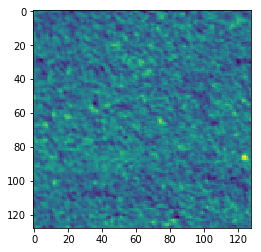

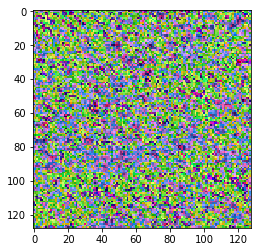

In [18]:
trX.shape
plt.imshow(trX[0,:,:,0]); plt.show()
plt.imshow(trX[0]); plt.show()

In [43]:
##trXX = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-XX.npy')
##trYY = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-YY.npy')
trXX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-XX.npy')
trYY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-YY.npy')
trX, trY = trXX[trYY[:,9]==0], trYY[trYY[:,9]==0] # not cloudy
trY=trY[:,range(0,9)+range(10,17)] # --cloudy
del trXX,trYY
print(trX.shape,trY.shape)

(12048, 64, 64, 3) (12048, 16)


In [27]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

In [34]:
#nameAsk = os.listdir(teDirI); print(len(nameAsk))
nameAsk = os.listdir(teDirJPG); print(len(nameAsk))
trOX, trOY, i, ii, size = [], [], 0, 0, len(nameAsk)
print(datetime.datetime.now(),len(nameAsk),size)
for nn in nameAsk[0:size] :
    #nf = os.path.join(teDirTIF,nn);
    nf = os.path.join(teDirJPG,nn);
    nx = formImExt(nf,resize=(64,64))
    if (nx is not None) :
        trOX.append(nx)
        trOY.append(nn)
    i += 1
    if (i%10000==0) and (i>1) :
        if (ii==0) :
            trOX = np.array(trOX); trOX = trOX / 255.0
            trP = model.predict(trOX, batch_size=512); 
        else :
            trOX = np.array(trOX);  trOX = trOX / 255.0
            trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
        trOX,ii = [],ii+1;
    if (i%5000==0) : print(datetime.datetime.now(),"\t",ii,'\t',i,"\t",nn,'\t',(trP.shape if ii>0 else ""))

if (len(trOX)>0) :
    if (ii==0) :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = model.predict(trOX, batch_size=512); 
    else :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
    trOX,ii = [],ii+1;
    
print(datetime.datetime.now())

#assert (size!=len(trOY)), "Wrong files {} != {}".format(size,len(trOY))

61191
2017-05-20 05:46:19.287685 61191 61191
2017-05-20 05:46:38.218814 	 0 	 5000 	 test_14523.jpg 	 
2017-05-20 05:46:51.023731 	 1 	 10000 	 test_19029.jpg 	 (10000, 17)
2017-05-20 05:46:58.884016 	 1 	 15000 	 test_23524.jpg 	 (10000, 17)
2017-05-20 05:47:09.507695 	 2 	 20000 	 test_28015.jpg 	 (20000, 17)
2017-05-20 05:47:16.475888 	 2 	 25000 	 test_32520.jpg 	 (20000, 17)
2017-05-20 05:47:26.837760 	 3 	 30000 	 test_37026.jpg 	 (30000, 17)
2017-05-20 05:47:33.858034 	 3 	 35000 	 test_4908.jpg 	 (30000, 17)
2017-05-20 05:47:44.019579 	 4 	 40000 	 test_9402.jpg 	 (40000, 17)
2017-05-20 05:47:51.298769 	 4 	 45000 	 file_13913.jpg 	 (40000, 17)
2017-05-20 05:48:01.555641 	 5 	 50000 	 file_18419.jpg 	 (50000, 17)
2017-05-20 05:48:24.538867 	 5 	 55000 	 file_4564.jpg 	 (50000, 17)
2017-05-20 05:48:40.785101 	 6 	 60000 	 file_892.jpg 	 (60000, 17)
2017-05-20 05:48:43.863555


In [36]:
#trOX = np.array(trOX);
trOY = np.array([os.path.splitext(x)[0] for x in trOY]);
print(len(nameAsk),trP.shape,trOY.shape)

61191 (61191, 17) (61191,)


In [ ]:
# Saving & Loading

In [26]:
np.save('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy',trOX)
np.save('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy',trOY)

In [27]:
trOX = np.load('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy')
trOY = np.load('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy')
print(trOX.shape,trOY.shape)

(61191, 32, 32, 6) (61191,)


In [37]:
rrx
rrd=dict()
for i in range(len(rrx)) :
    rrd[i]=rrx[i]
rrd

{0: 0.75841929007857778,
 1: 0.98263848366246676,
 2: 0.84722629763157453,
 3: 0.97604678247993626,
 4: 0.78729476795032916,
 5: 0.78956810256787635,
 6: 0.83083164404299403,
 7: 0.73801616416924898,
 8: 0.6761901702314258,
 9: 0.86068787363532673,
 10: 0.96403428373772715,
 11: 0.90053737661152566,
 12: 0.6528441526860862,
 13: 0.86359942524081812,
 14: 0.37037005520335736,
 15: 0.68382329252278806,
 16: 0.58917169677281178}

In [258]:
#Forming result

In [30]:
#trP = model.predict(trOX, batch_size=512); 
trP.shape, trP[-1]

((61191, 17), array([  6.56801313e-02,   7.46541142e-01,   2.32726157e-01,
          9.55386758e-01,   1.95543230e-01,   9.11955476e-01,
          8.89197826e-01,   2.53069662e-02,   1.54045611e-05,
          7.43342913e-04,   6.54759035e-02,   6.17289741e-04,
          8.51887614e-02,   2.95602629e-04,   2.64362683e-07,
          1.03749386e-04,   2.92145728e-07], dtype=float32))

In [38]:
trM=np.array([0.0]*len(labels)); print(trM.shape)
wr = [labels.index(i) for i in weather_labels];
tt=trM; trM[:]=0.5
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

(17,)
[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.5, 0.5, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 2.0, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [39]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trPP = [weather_labels[trP[i,wr].argmax()]] + [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])];
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'clear primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.   0.5  0.5  2.   0.5  0.5  0.5  0.5  0.5  2.   2.   0.5  0.5  0.5  0.5
  0.5  0.5] [  1.63650557e-01   3.91220033e-01   1.36160061e-01   9.47374701e-01
   9.09343541e-01   1.55211976e-02   3.13203782e-02   1.42206885e-02
   8.06170846e-08   9.10553038e-01   7.85041321e-03   4.12757437e-08
   6.71853591e-03   1.33155788e-06   7.46736941e-06   9.65268737e-06
   7.95199711e-08]


In [40]:
print(labels)
#print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [41]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-05-20-05-51-18
